In [1]:
import calendar 
import datetime
import dask.dataframe as dd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import SVG, display

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')
#plt.style.available

In [3]:
%%time
# set data file path
parquet_data_folder = '../data/crimes-2017.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2017.snappy.parq
Crime data loaded into memory.
Wall time: 3.19 s


In [4]:
%%time
# log records count and data partitions
print('Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Crime data stats:
---------------------------------------
172,030 total records in 1 partitions
DataFrame size: 2,408,420
Wall time: 0 ns


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,FBICode,Description,LocationDescription,CommunityArea,Beat,District,Ward,Arrest,Domestic,Latitude,Longitude,Year
npartitions=1,,,,,,,,,,,,,,
2017-01-01 00:00:00,object,category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],bool,bool,float64,float64,category[unknown]
2017-08-25 23:59:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
# preview crimes data with Date index
crimes.head()

,Block,PrimaryType,FBICode,Description,LocationDescription,CommunityArea,Beat,District,Ward,Arrest,Domestic,Latitude,Longitude,Year
Date,,,,,,,,,,,,,,
2017-01-01,088XX S PRINCETON AVE,OFFENSE INVOLVING CHILDREN,20,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,49.0,634,6,21.0,False,False,NaN,NaN,2017
2017-01-01,013XX S KOMENSKY AVE,OFFENSE INVOLVING CHILDREN,20,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,29.0,1011,10,24.0,False,True,NaN,NaN,2017
2017-01-01,044XX S HERMITAGE AVE,OFFENSE INVOLVING CHILDREN,02,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,61.0,924,9,12.0,False,True,NaN,NaN,2017
2017-01-01,016XX W WABANSIA AVE,DECEPTIVE PRACTICE,11,FRAUD OR CONFIDENCE GAME,RESIDENCE,24.0,1433,14,1.0,False,False,NaN,NaN,2017
2017-01-01,023XX N LEAVITT ST,DECEPTIVE PRACTICE,11,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,22.0,1432,14,32.0,False,False,NaN,NaN,2017


In [7]:
# get crime types and counts by primary type
crime_types = crimes[['PrimaryType']]
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# print crime stats
print(crime_type_total.sort_values(ascending=False))
print("...\nTotal Primary Crime Types: {:,}".format(crime_type_total.size))

PrimaryType
THEFT                                40644
BATTERY                              32375
CRIMINAL DAMAGE                      19118
ASSAULT                              12669
OTHER OFFENSE                        11599
DECEPTIVE PRACTICE                   11075
BURGLARY                              8393
MOTOR VEHICLE THEFT                   7331
ROBBERY                               7324
NARCOTICS                             7123
CRIMINAL TRESPASS                     4544
WEAPONS VIOLATION                     3077
OFFENSE INVOLVING CHILDREN            1390
PUBLIC PEACE VIOLATION                1009
CRIM SEXUAL ASSAULT                    971
INTERFERENCE WITH PUBLIC OFFICER       729
SEX OFFENSE                            598
PROSTITUTION                           562
HOMICIDE                               444
ARSON                                  301
LIQUOR LAW VIOLATION                   144
STALKING                               137
GAMBLING                               134

In [8]:
# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic + total)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic  Total
PrimaryType                                               
THEFT                              4048.0    1533.0  40644
BATTERY                            6424.0   15728.0  32375
CRIMINAL DAMAGE                    1143.0    2229.0  19118
ASSAULT                            2251.0    3257.0  12669
OTHER OFFENSE                      2572.0    3612.0  11599
DECEPTIVE PRACTICE                  406.0     101.0  11075
BURGLARY                            311.0     115.0   8393
MOTOR VEHICLE THEFT                 574.0      72.0   7331
ROBBERY                             445.0     132.0   7324
NARCOTICS                          7043.0       5.0   7123
CRIMINAL TRESPASS                  2720.0     223.0   4544
WEAPONS VIOLATION                  2446.0      11.0   3077
OFFENSE INVOLVING CHILDREN          163.0     686.0   1390
PUBLIC PEACE VIOLATION              680.0      32.0   1009
CRIM SEXUAL ASSAULT                  38.0     133.0    9

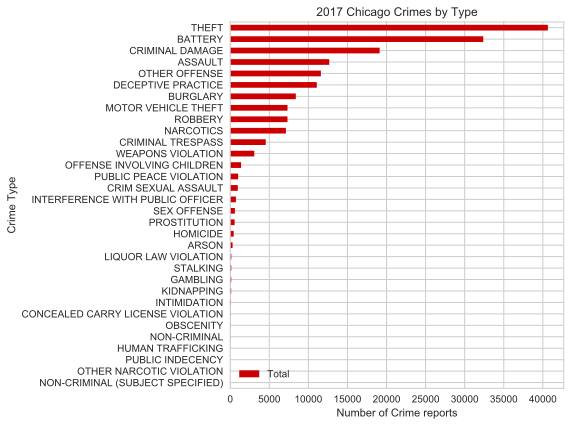

In [9]:
# plot crimes by primary type counts
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True)\
.drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(8,6), color='#cc0000')
plt.title('2017 Chicago Crimes by Type')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

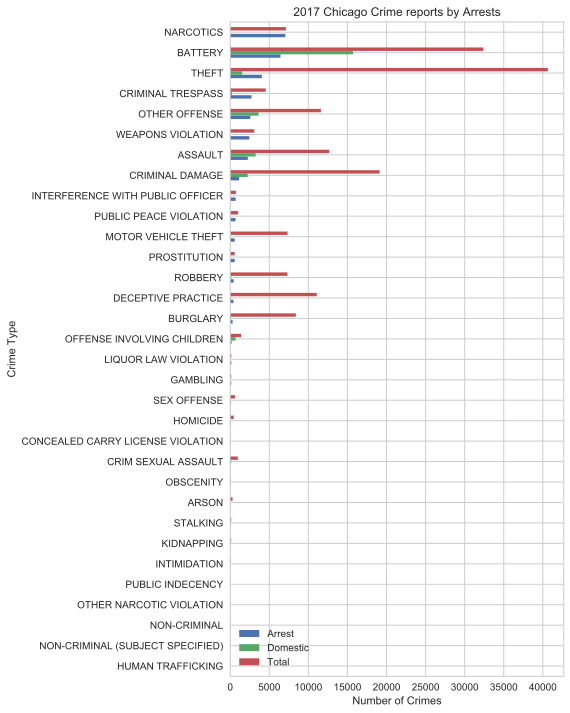

In [10]:
# plot crimes by arrests
crime_type_counts.sort_values(by='Arrest', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Arrests')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

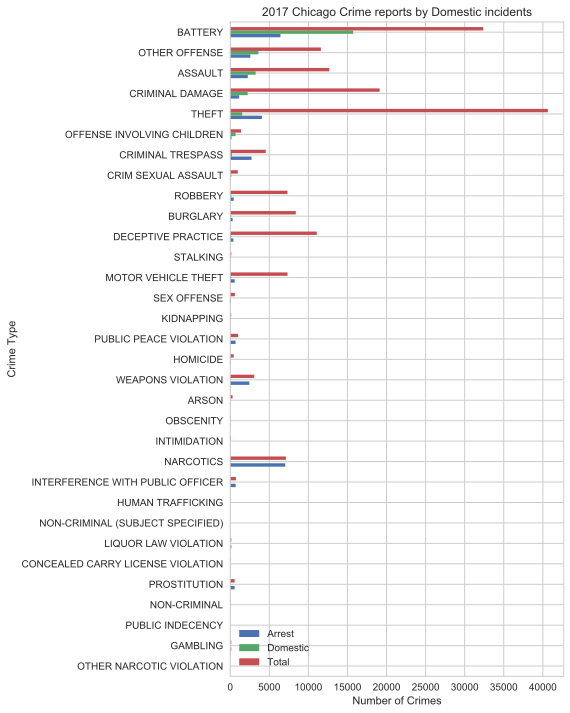

In [11]:
# plot crimes by domestic incident reports
crime_type_counts.sort_values(by='Domestic', ascending=True)\
.plot(kind='barh', figsize=(8,10))
plt.title('2017 Chicago Crime reports by Domestic incidents')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.tight_layout()
plt.show()

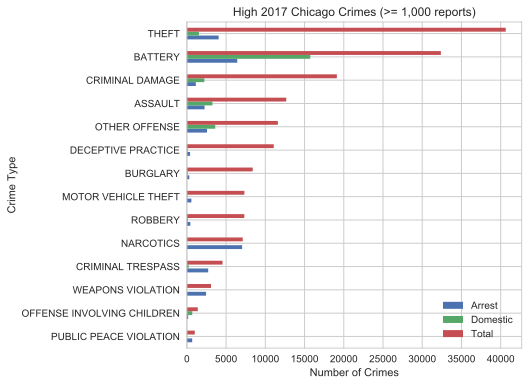

In [12]:
# plot high crimes (>-= 1,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('High 2017 Chicago Crimes (>= 1,000 reports)')
plt.show()

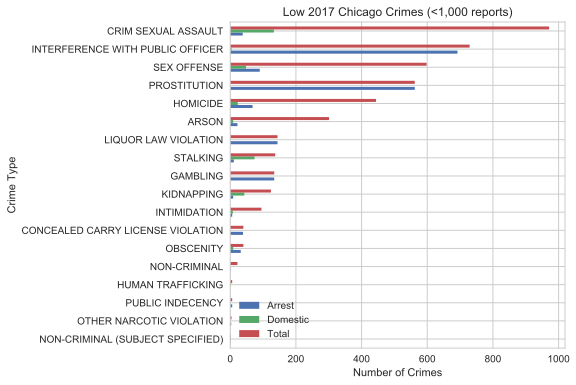

In [13]:
# plot less than 1000 crime reports types
crime_type_counts[crime_type_counts['Total'] < 1000]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Low 2017 Chicago Crimes (<1,000 reports)')
plt.show()

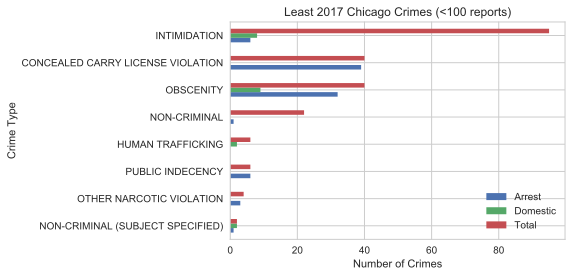

In [14]:
# plot less than 100 crime reports types
crime_type_counts[crime_type_counts['Total'] < 100]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4))
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Least 2017 Chicago Crimes (<100 reports)')
plt.show()

In [15]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       38928
RESIDENCE    29228
APARTMENT    21467
SIDEWALK     13807
OTHER         7101
Name: Total, dtype: int64
...
Total Locations: 123


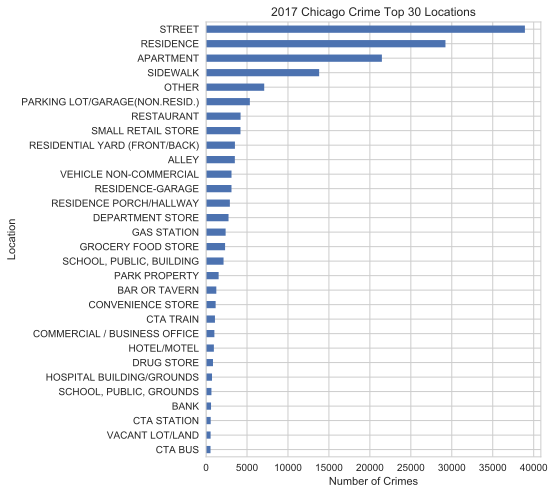

In [16]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True)\
.plot(kind='barh', figsize=(6,8))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top 30 Locations')
plt.show()

In [17]:
# get arrests and domestic counts for each location description
crime_location_counts = crimes[['LocationDescription', 'Arrest', 'Domestic']]\
.groupby('LocationDescription').sum().compute()

# add crime location totals column
crime_location_counts['Total'] = crime_locations
crime_location_counts.head()

,Arrest,Domestic,Total
LocationDescription,,,
RESIDENCE,3096.0,9896.0,29228
APARTMENT,3131.0,9263.0,21467
OTHER,676.0,530.0,7101
RESTAURANT,579.0,115.0,4214
COMMERCIAL / BUSINESS OFFICE,105.0,26.0,1017


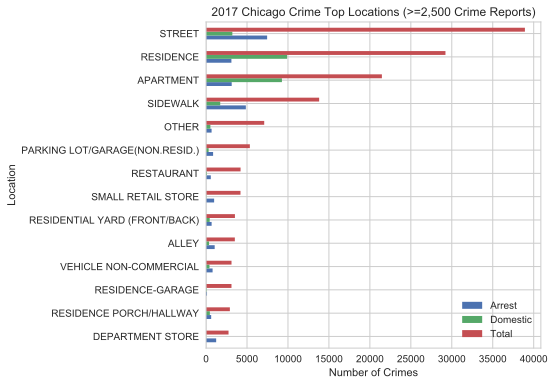

In [18]:
# plot top crime locations with arrests and domestic crime counts
crime_location_counts[crime_location_counts['Total'] >= 2500]\
.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Top Locations (>=2,500 Crime Reports)')
plt.show()

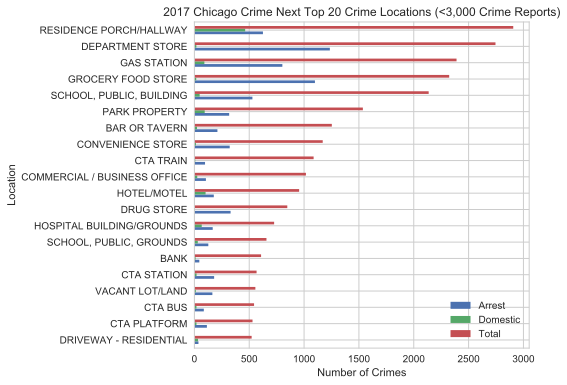

In [19]:
# plot next 20 top crime locations
crime_location_counts = crime_location_counts[crime_location_counts['Total'] <= 3000]\
.sort_values(by='Total', ascending=False)
crime_location_counts[:20].sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,6))
plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime Next Top 20 Crime Locations (<3,000 Crime Reports)')
plt.show()

In [20]:
# check for datetime64 index to plot crime over time
crimes.index

Dask Index Structure:
npartitions=1
2017-01-01 00:00:00    datetime64[ns]
2017-08-25 23:59:00               ...
Name: Date, dtype: datetime64[ns]
Dask Name: read-parquet, 2 tasks

In [21]:
# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

Date
2017-01-01 00:00:00    True
2017-01-01 00:00:00    True
2017-01-01 00:00:00    True
2017-01-01 00:00:00    True
2017-01-01 00:01:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 33,084


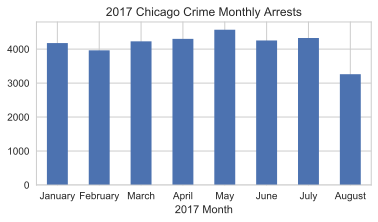

In [22]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(kind='bar', figsize=(6,3))
plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.xlabel('2017 Month')
plt.title('2017 Chicago Crime Monthly Arrests')
plt.show()

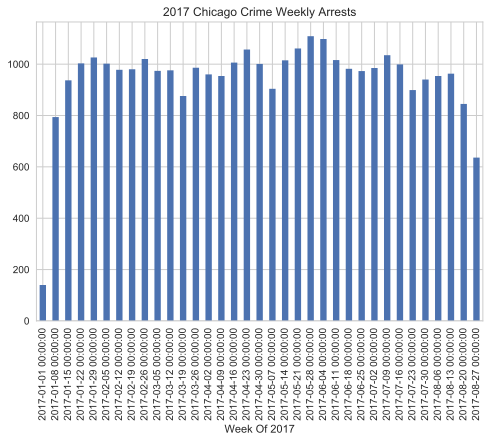

In [23]:
# plot weekly arrests
weekly_arrests = arrests.resample('W').sum().compute()
weekly_arrests.plot(kind='bar')
# TODO: format weekly xticks to only list week start date
plt.xlabel('Week Of 2017')
plt.title('2017 Chicago Crime Weekly Arrests')
plt.show()

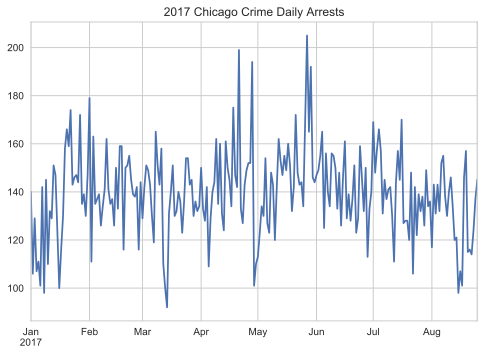

In [24]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('2017 Chicago Crime Daily Arrests')
plt.show()

In [25]:
# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))

Date
2017-01-01    True
2017-01-01    True
2017-01-01    True
2017-01-01    True
2017-01-01    True
Name: Domestic, dtype: bool
...
Total Domestic: 28,092


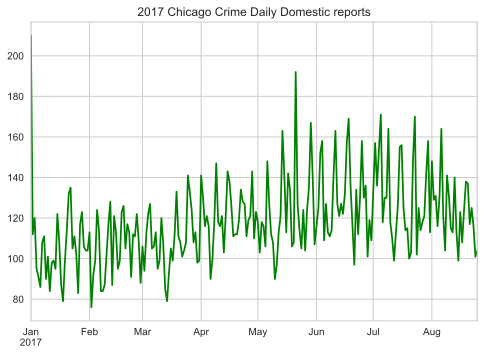

In [26]:
# plot daily domestic crimes
daily_domestic = domestic.resample('D').sum().compute()
daily_domestic.plot(color='g')
plt.title('2017 Chicago Crime Daily Domestic reports')
plt.show()

In [27]:
# get daily total crime counts
daily_crime = crime_types.resample('D').count().compute()

#print daily total crime stats
print(daily_crime.head())
print("...\nTotal Days: {:,}".format(daily_crime.size))

            PrimaryType
2017-01-01          940
2017-01-02          601
2017-01-03          706
2017-01-04          610
2017-01-05          601
...
Total Days: 237


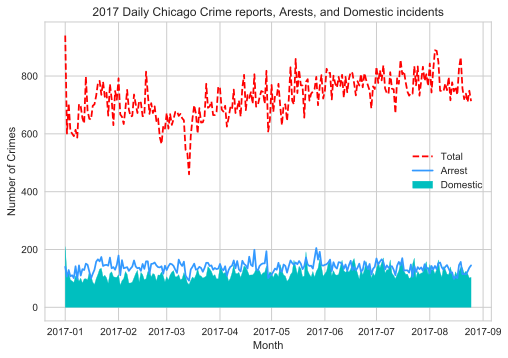

In [28]:
# plot daily crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, '--', label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='#3399ff', zorder=10)
ax.fill_between(daily_domestic.index, daily_domestic, label='Domestic', color='c')
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Month')
ax.legend(loc='right')
plt.title('2017 Daily Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [29]:
# get select human endangerment crimes
violent_crimes = crime_types[(crime_types['PrimaryType']=='CRIM SEXUAL ASSAULT') | \
                             (crime_types['PrimaryType']=='HOMICIDE') | \
                             (crime_types['PrimaryType']=='HUMAN TRAFFICKING') | \
                             (crime_types['PrimaryType']=='KIDNAPPING') | \
                             (crime_types['PrimaryType']=='OFFENSE INVOLVING CHILDREN')]

# print violent crimes stats
print(violent_crimes.head(10))
print('...............................................')
print(violent_crimes.PrimaryType.value_counts().head(5))

                           PrimaryType
Date                                  
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01  OFFENSE INVOLVING CHILDREN
2017-01-01         CRIM SEXUAL ASSAULT
2017-01-01  OFFENSE INVOLVING CHILDREN
...............................................
OFFENSE INVOLVING CHILDREN    1390
CRIM SEXUAL ASSAULT            971
HOMICIDE                       444
KIDNAPPING                     124
HUMAN TRAFFICKING                6
Name: PrimaryType, dtype: int64


In [30]:
# categorize by primary type
violent_crimes = violent_crimes.categorize(columns='PrimaryType')
print(violent_crimes)

# print selected violent crimes primary type categories
print('\nSelected Primary Type categories:')
print('----------------------------------------------------------------------')
print(violent_crimes.PrimaryType.cat.categories)

Dask DataFrame Structure:
                         PrimaryType
npartitions=1                       
2017-01-01 00:00:00  category[known]
2017-08-25 23:59:00              ...
Dask Name: _categorize_block, 14 tasks

Selected Primary Type categories:
----------------------------------------------------------------------
Index(['OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE', 'OTHER OFFENSE',
       'CRIMINAL TRESPASS', 'CRIMINAL DAMAGE', 'SEX OFFENSE', 'THEFT',
       'CRIM SEXUAL ASSAULT', 'OBSCENITY', 'ASSAULT', 'BATTERY',
       'MOTOR VEHICLE THEFT', 'INTIMIDATION', 'ROBBERY', 'WEAPONS VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'PUBLIC PEACE VIOLATION',
       'BURGLARY', 'NARCOTICS', 'HOMICIDE', 'KIDNAPPING', 'ARSON', 'STALKING',
       'CONCEALED CARRY LICENSE VIOLATION', 'PROSTITUTION', 'NON-CRIMINAL',
       'LIQUOR LAW VIOLATION', 'PUBLIC INDECENCY', 'GAMBLING',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'HUMAN TRAFFICKING',
       'OTHER NARCOTIC VIOLATION'],
    

In [31]:
# group violent crimes by month and crime type
violent_crimes_groupby = violent_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
violent_crime_data = violent_crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(violent_crime_data.head(10))
print('...')

# unstack violent crime type group for series plotting
violent_crime_data = violent_crime_data.unstack()
print(violent_crime_data.head(12))

print("...\nTotal Monthly/Type records: {:,}".format(violent_crime_data.size))

Date        PrimaryType               
2017-01-31  OFFENSE INVOLVING CHILDREN    218
            CRIM SEXUAL ASSAULT           135
            HOMICIDE                       53
            KIDNAPPING                      8
2017-02-28  OFFENSE INVOLVING CHILDREN    119
            CRIM SEXUAL ASSAULT           118
            HOMICIDE                       48
            KIDNAPPING                     13
2017-03-31  OFFENSE INVOLVING CHILDREN    175
            CRIM SEXUAL ASSAULT            96
Name: Count, dtype: int64
...
PrimaryType  OFFENSE INVOLVING CHILDREN  CRIM SEXUAL ASSAULT  HOMICIDE  \
Date                                                                     
2017-01-31                        218.0                135.0      53.0   
2017-02-28                        119.0                118.0      48.0   
2017-03-31                        175.0                 96.0      37.0   
2017-04-30                        172.0                131.0      46.0   
2017-05-31                 

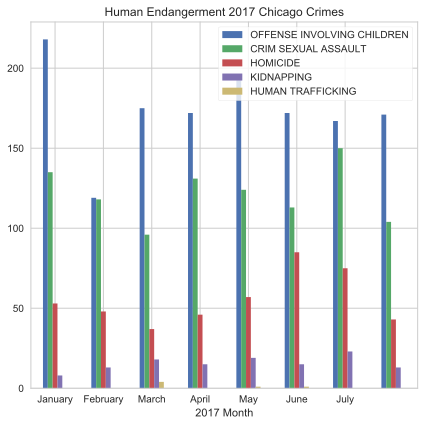

In [32]:
# plot violent crime data
violent_crime_data.plot(figsize=(6,6), kind='bar')
plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Human Endangerment 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [33]:
# get top 5 crimes
top_5_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                             (crime_types['PrimaryType']=='BATTERY') | \
                             (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                             (crime_types['PrimaryType']=='ASSAULT') | \
                             (crime_types['PrimaryType']=='OTHER OFFENSE')]
top_5_crimes.head(10)

,PrimaryType
Date,
2017-01-01,OTHER OFFENSE
2017-01-01,CRIMINAL DAMAGE
2017-01-01,CRIMINAL DAMAGE
2017-01-01,THEFT
2017-01-01,OTHER OFFENSE
2017-01-01,OTHER OFFENSE
2017-01-01,ASSAULT
2017-01-01,THEFT
2017-01-01,CRIMINAL DAMAGE


In [34]:
# print top 5 crime counts
top_5_crimes.PrimaryType.value_counts().head()

THEFT              40644
BATTERY            32375
CRIMINAL DAMAGE    19118
ASSAULT            12669
OTHER OFFENSE      11599
Name: PrimaryType, dtype: int64

In [35]:
print('Monthly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by month and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))

Monthly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-31  OTHER OFFENSE      1551
            CRIMINAL DAMAGE    2407
            THEFT              4927
            ASSAULT            1373
            BATTERY            3557
2017-02-28  OTHER OFFENSE      1373
            CRIMINAL DAMAGE    2044
            THEFT              4376
            ASSAULT            1294
            BATTERY            3407
Name: Count, dtype: int64
...
PrimaryType  OTHER OFFENSE  CRIMINAL DAMAGE  THEFT  ASSAULT  BATTERY
Date                                                                
2017-01-31            1551             2407   4927     1373     3557
2017-02-28            1373             2044   4376     1294     3407
2017-03-31            1508             2232   4471     1481     3851
2017-04-30            1551             2440   4761     1635     4097
2017-05-31            1611             2508   5303     1847     4554
201

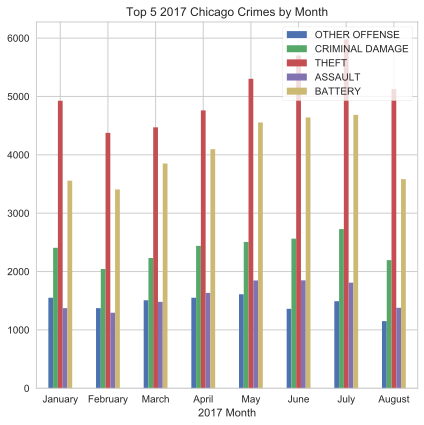

In [36]:
# plot top 5 crimes data
top_5_crime_data.plot(figsize=(6,6), kind='bar')

plt.xticks([0,1,2,3,4,5,6,7], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.xlabel('2017 Month')
plt.title('Top 5 2017 Chicago Crimes by Month')
plt.tight_layout()
plt.show()

In [37]:
print('Weekly Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by week and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('W'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Weekly Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  OTHER OFFENSE       72
            CRIMINAL DAMAGE    113
            THEFT              178
            ASSAULT             45
            BATTERY            203
2017-01-08  OTHER OFFENSE      336
            CRIMINAL DAMAGE    477
            THEFT              909
            ASSAULT            300
            BATTERY            714
Name: Count, dtype: int64
...
PrimaryType  OTHER OFFENSE  CRIMINAL DAMAGE  THEFT  ASSAULT  BATTERY
Date                                                                
2017-01-01              72              113    178       45      203
2017-01-08             336              477    909      300      714
2017-01-15             383              524   1076      292      766
2017-01-22             349              568   1234      338      814
2017-01-29             318              569   1198      312      824
2017-02-05    

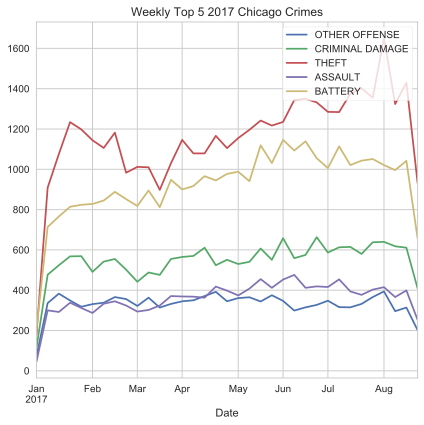

In [38]:
# add weekly arrests data for comparison of crime fighting efforts
#top_5_crime_data['Arrests'] = weekly_arrests

# plot Weekly top 5 crimes data
top_5_crime_data.plot(figsize=(6,6))
plt.legend(loc='upper right', frameon=True)
plt.title('Weekly Top 5 2017 Chicago Crimes')
plt.tight_layout()
plt.show()

In [39]:
print('Daily Top 5 Crime Data:')
print('---------------------------------------------------------------------')

# group top 5 crimes by day and crime type
crimes_groupby = top_5_crimes.groupby([pd.TimeGrouper('D'), 'PrimaryType'])
top_5_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_5_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_5_crime_data = top_5_crime_data.unstack()
print(top_5_crime_data.head(10))
print('...')

Daily Top 5 Crime Data:
---------------------------------------------------------------------
Date        PrimaryType    
2017-01-01  OTHER OFFENSE       72
            CRIMINAL DAMAGE    113
            THEFT              178
            ASSAULT             45
            BATTERY            203
2017-01-02  OTHER OFFENSE       44
            CRIMINAL DAMAGE     73
            THEFT              120
            ASSAULT             38
            BATTERY            105
Name: Count, dtype: int64
...
PrimaryType  OTHER OFFENSE  CRIMINAL DAMAGE  THEFT  ASSAULT  BATTERY
Date                                                                
2017-01-01              72              113    178       45      203
2017-01-02              44               73    120       38      105
2017-01-03              43               79    149       55      114
2017-01-04              54               57    161       34       95
2017-01-05              56               68    132       42       84
2017-01-06     

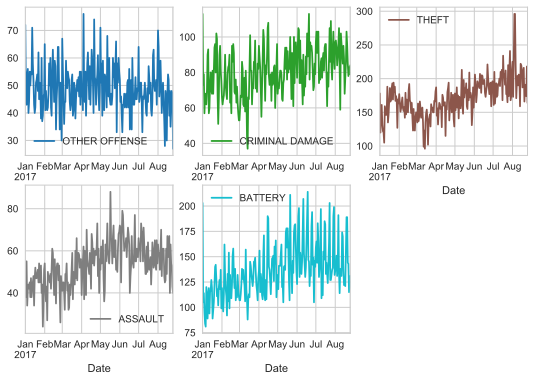

In [40]:
# add daily arrests data for comparison of crime fighting efforts
#top_5_crime_data['Arrests'] = daily_arrests

# plot top 5 daily crimes grid
top_5_crime_data.plot(figsize=(9, 6), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [41]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

,CommunityArea,CommunityName,Side
0,0,NaN,NaN
1,1,Rogers Park,Far North Side
2,2,West Ridge,Far North Side
3,3,Uptown,Far North Side
4,4,Lincoln Square,Far North Side


In [42]:
# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName       Side  Total
25             25           Austin  West Side  10060
8               8  Near North Side    Central   7503
32             32             Loop    Central   6673
28             28   Near West Side  West Side   5793
29             29   North Lawndale  West Side   5711
...
Total Communities: 77


D:\tools\dev\python\Anaconda3-4.2.0\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [43]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,10060
Near North Side,7503
Loop,6673
Near West Side,5793
North Lawndale,5711


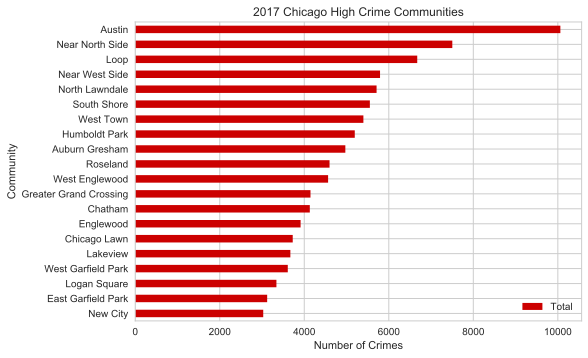

In [44]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh', color='#cc0000')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago High Crime Communities')
plt.show()

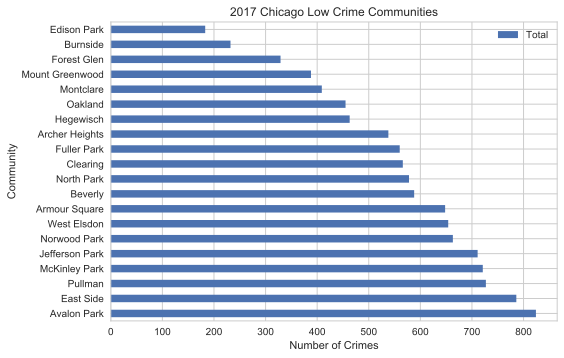

In [45]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False).plot(kind='barh')
plt.ylabel('Community')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Low Crime Communities')
plt.show()

In [46]:
community_areas.head()

,CommunityArea,CommunityName,Side,Total
0,0,NaN,NaN,1
1,1,Rogers Park,Far North Side,2613
2,2,West Ridge,Far North Side,2253
3,3,Uptown,Far North Side,2206
4,4,Lincoln Square,Far North Side,1220


In [47]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum().drop('CommunityArea', axis=1) # denotes column
crime_by_side

,Total
Side,
Central,15401
Far North Side,14996
Far Southeast Side,20143
Far Southwest Side,10916
North Side,12178
Northwest Side,9351
South Side,22445
Southwest Side,23045
West Side,43554


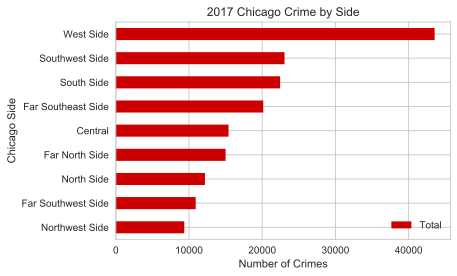

In [48]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4), color='#cc0000')
plt.ylabel('Chicago Side')
plt.xlabel('Number of Crimes')
plt.title('2017 Chicago Crime by Side')
plt.show()

In [49]:
# show Chicago sides svg for reference
display(SVG(url='../data/chicago-community-areas.svg'))

<IPython.core.display.SVG object>

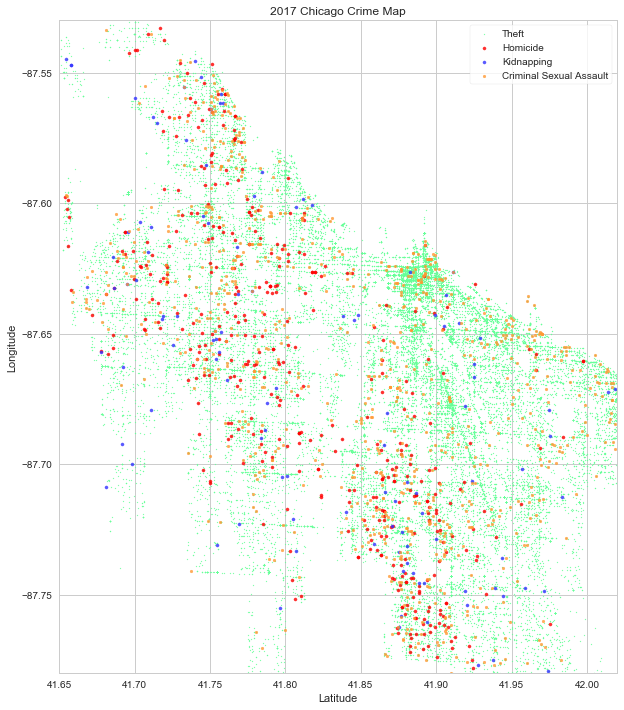

Wall time: 1.36 s


In [50]:
%%time

# get crime geo data
crime_geo = crimes[['PrimaryType', 'Latitude', 'Longitude']].dropna()

# get homicides
homicides = crime_geo[(crime_geo['PrimaryType']=='HOMICIDE')]\
.compute()

# get kidnappings
kidnappings = crime_geo[(crime_geo['PrimaryType']=='KIDNAPPING')]\
.compute()

# get criminal sexual assaults
sexual_assaults = crime_geo[(crime_geo['PrimaryType']=='CRIM SEXUAL ASSAULT')]\
.compute()

# get thefts
thefts = crime_geo[(crime_geo['PrimaryType']=='THEFT')]\
.compute()

# create scatter map plot
%config InlineBackend.figure_format = 'png'
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.65, 42.02) # (minLat, maxLat)
plt.ylim(-87.78, -87.53) # (minLong, maxLong)
#ax.set_facecolor('black')

# plot thefts, homicides, kidnappings and sexual assaults
ax.scatter(thefts['Latitude'], thefts['Longitude'],\
           s=1, alpha=0.8, color='#66ff99', label='Theft')
ax.scatter(homicides['Latitude'], homicides['Longitude'],\
                            s=10, alpha=0.8, color='#ff0000', label='Homicide')
ax.scatter(kidnappings['Latitude'], kidnappings['Longitude'],\
                            s=10, alpha=0.8, color='#3333ff', label='Kidnapping')
ax.scatter(sexual_assaults['Latitude'], sexual_assaults['Longitude'],\
                            s=8, alpha=0.8, color='#ff9933', label='Criminal Sexual Assault')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('2017 Chicago Crime Map')
plt.legend(loc='upper right', frameon=True)
plt.show()